In [1]:
#linear algebra
import numpy as np 
import math

#data tools
from copy import copy
import pandas as pd
from scipy.stats import boxcox
from scipy.special import boxcox1p
from scipy.special import inv_boxcox
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image

#plots
import seaborn as sns
import matplotlib.pyplot as plt

#models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 

#model interpretation modules
import lime
import lime.lime_tabular
import shap
import eli5

#metrics
from sklearn.metrics import mean_squared_error, r2_score

#awesome interactive map library
import folium
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster

#statistics
from scipy import stats

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
# Image('../input/new-york-city-airbnb-png/New York City Airbnb.png')

# About Airbnb

Airbnb is an online marketplace for renting and booking private accomodations. The company was conceived in 2008 after its founders rented out an air mattress in their living room, effectively turning their apartment into a bed and breakfast, to offset the high cost of rent in San Francisco. Airbnb is a shortened version of its original name, AirBedandBreakfast.com. Currently on Airbnb there are 2.9 million advertisements in around 81.000 cities and 191 countries. Airbnb is very sucessful mainly by solving following problems:
* ****Saved money****
Hotel prices for some for us are sometimes quite high and we don’t have the money to stay there. By opening up the possibility of private accommodation, the prices of accommodation costs have been reduced. Having several “accomodation” providers, competing for the customer, the price will always decrease. Furthermore, platform like Airbnb can concentrate thousands of places to stay in a single city. More offer, more options.
* ****Unused space****
Many people have unused space at home. Airbnb has made it possible to find additional income in way that we hadn't even thought about before. For a short stay, even a small sleeping space can be useful. 
* ****Genuine human touch**** 
Unlike hotels, most of Airbnb objects provide accommodation where you feel like in your own home.

Thanks to the enormous popularity of portal, more than 260 million guests have booked and stayed in Airbnb properties across the world.

In [3]:
data = pd.read_csv('../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')

# Overview

Dataset overall shape.

In [4]:
print("Dataset contains {} samples of {} features.".format(data.shape[0],data.shape[1]))

Dataset contains 48895 samples of 16 features.


In [5]:
data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [6]:
data.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [7]:
print('Number of quantitative features: {}'.format(len([d for d in data.columns if data.dtypes[d] != 'object'])))
print('Number of qualitative features: {}'.format(len([d for d in data.columns if data.dtypes[d] == 'object'])))

Number of quantitative features: 10
Number of qualitative features: 6


Dropping unecessary features.

In [8]:
data.drop('id', axis=1, inplace=True)
data.drop('host_id', axis=1, inplace=True)
data.drop('name', axis=1, inplace=True)
data.drop('host_name', axis=1, inplace=True)

Correlations between price and most important features.

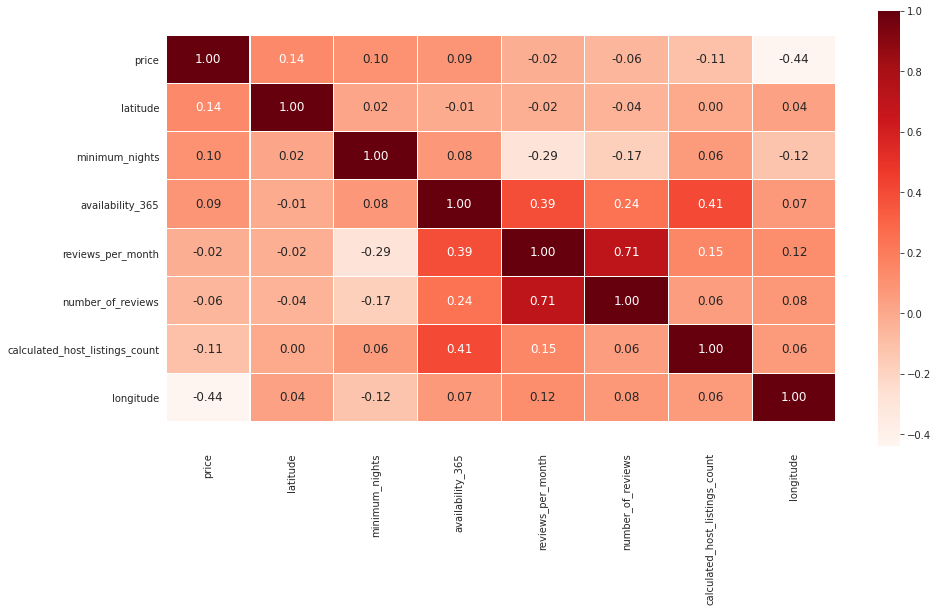

In [9]:
top = 8
corr = data[['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count','neighbourhood', 'neighbourhood_group', 'room_type', 'availability_365']].corr(method='spearman')
top8 = abs(corr.nlargest(top,'price')['price']).index
corr_top8 = data[top8].corr(method='spearman')
plt.figure(figsize=(15,8))
ax = sns.heatmap(corr_top8, annot=True, linewidths=0.1, fmt='.2f', cmap='Reds', annot_kws={'size':12})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('corr.png')

# Target - 'price'
The main objective of this dataset is to predict 'price' of a particular advertisement. 
So let us take a quick preview of our target variable - 'price'.

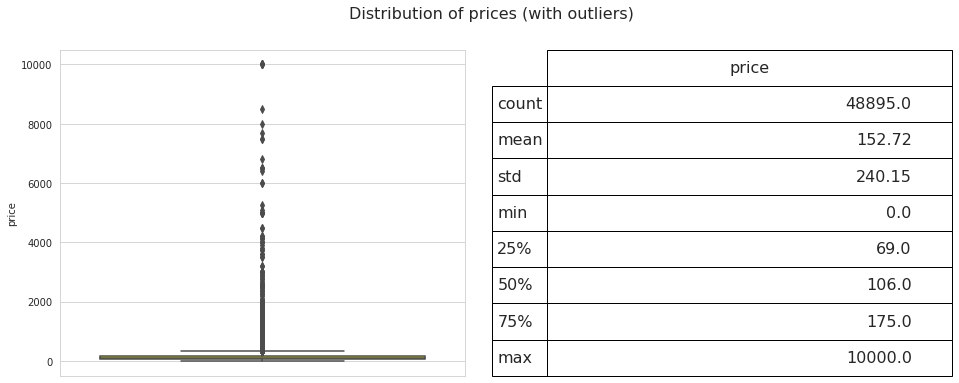

In [10]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(121)
# ax1.boxplot(data['price'])
sns.boxplot(y = data['price'], ax=ax1, color='yellow')
describe = data['price'].describe().to_frame().round(2)

ax2 = fig.add_subplot(122)
ax2.axis('off')
font_size = 16
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of prices (with outliers)', fontsize=16)
plt.show()

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


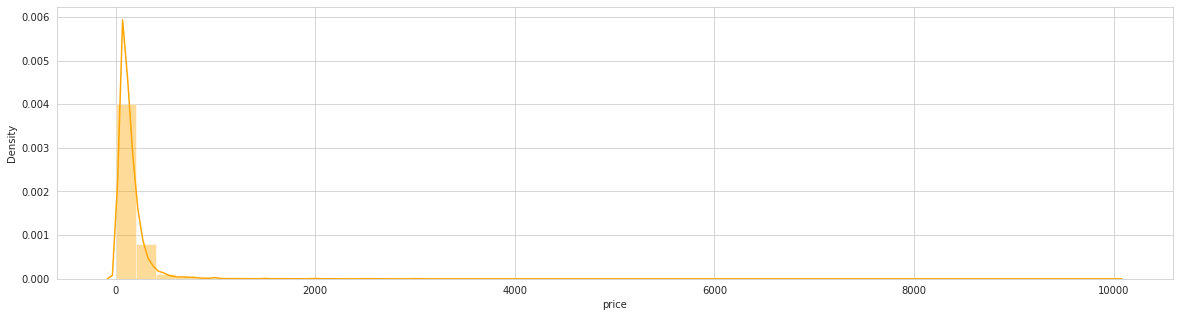

In [11]:
fig = plt.figure(figsize=(20,5))
sns.distplot(data['price'],color='orange')
plt.show()

Distribution of rental price is:
- Deviating from normal distribution. 
- Having appreciable positive skewness.
- Showing peakdness.
    
and also:

In [12]:
print('Skewness: {}'.format(data['price'].skew()))
#Skewness - measure of symmetry/assymetry of distribution. If the distribution is perfectly symmetrical, 
#the value of skewness is equal to 0. If skewness > 0 : positive, if skewness < 0 : negative
print('Kurtosis: {}'.format(data['price'].kurt()))
#Kurtosis - measure of flattening distribution of a feature. 

Skewness: 19.118938995046033
Kurtosis: 585.6728788988286


# Pairplot

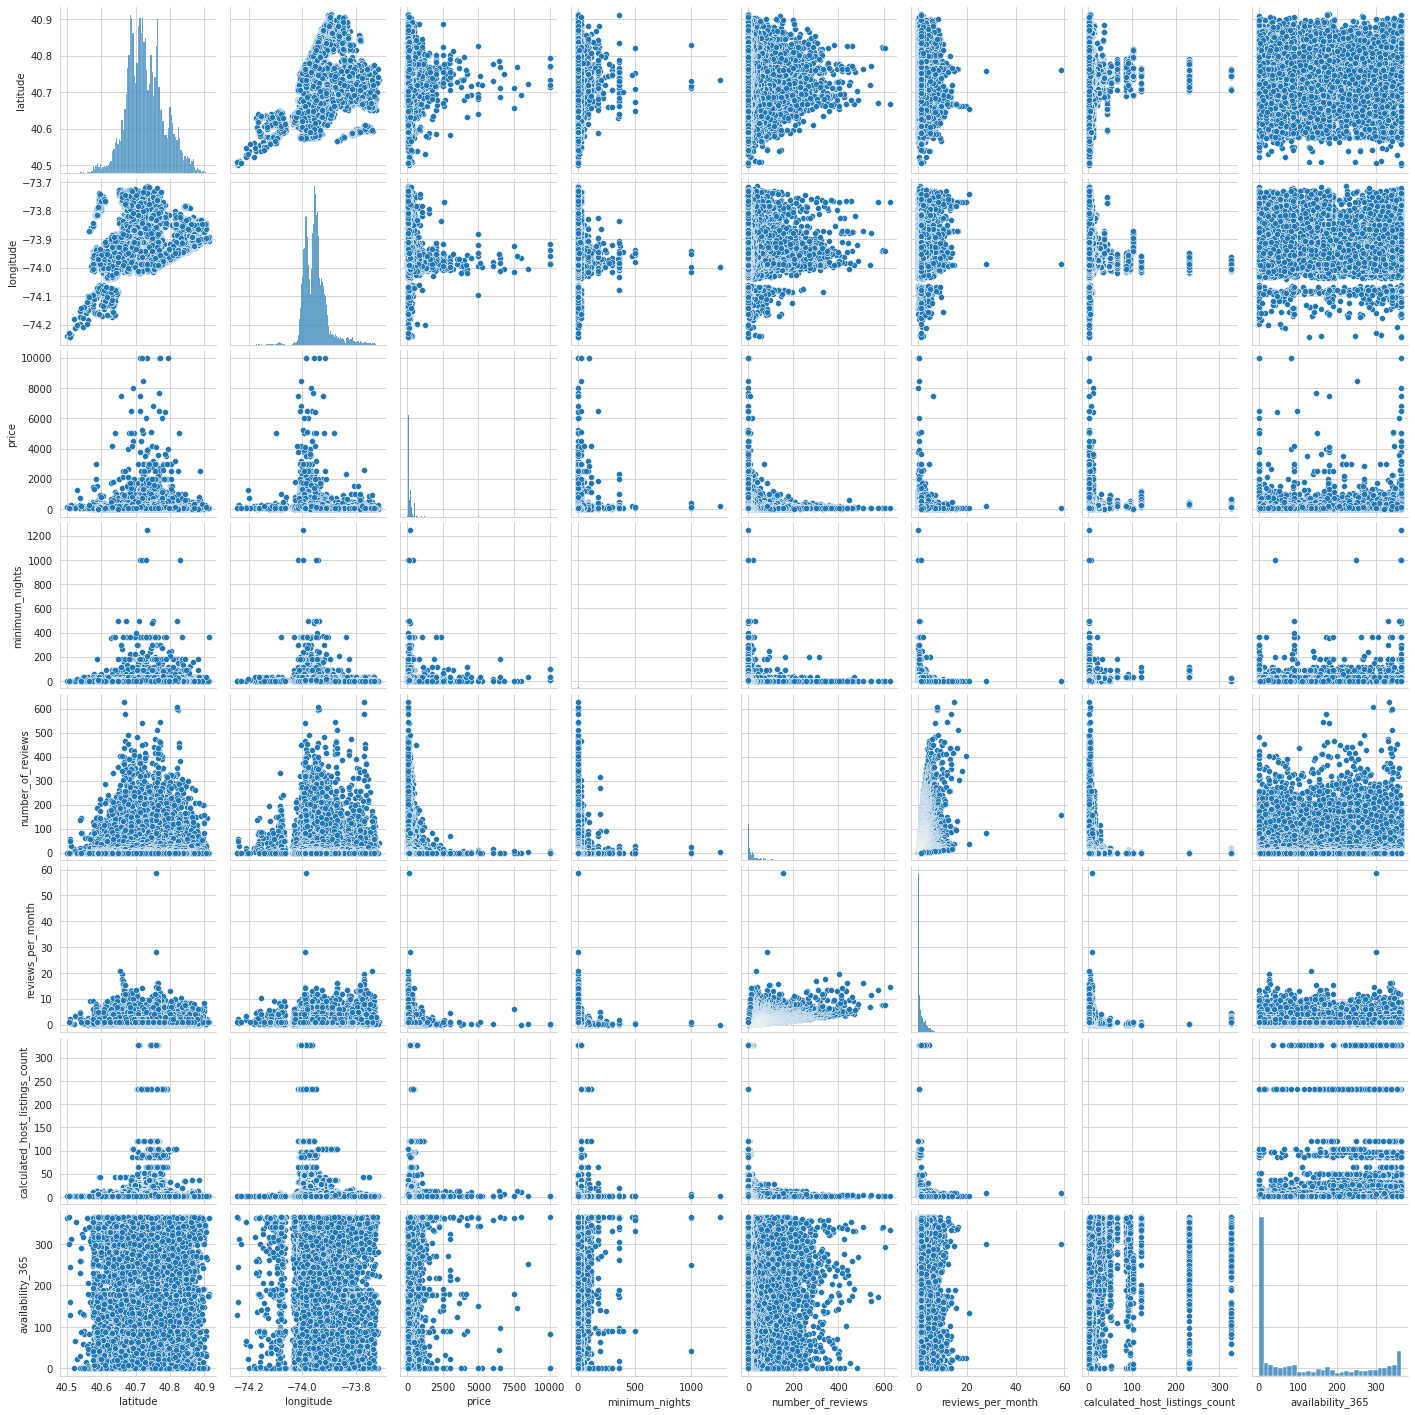

In [13]:
sns.pairplot(data)
plt.show()

# Data cleaning
Null values in dataset.

In [14]:
missing_values = data.isnull().sum().sort_values(ascending=False)
percentage_missing_values = round((data.isnull().sum()/data.isnull().sum().sum()).sort_values(ascending=False),3)
null_in_data = pd.concat([missing_values, percentage_missing_values],keys=['Missing values','Percentage'],axis=1)
null_in_data.head(2)

Missing values  Percentage
reviews_per_month           10052         0.5
last_review                 10052         0.5

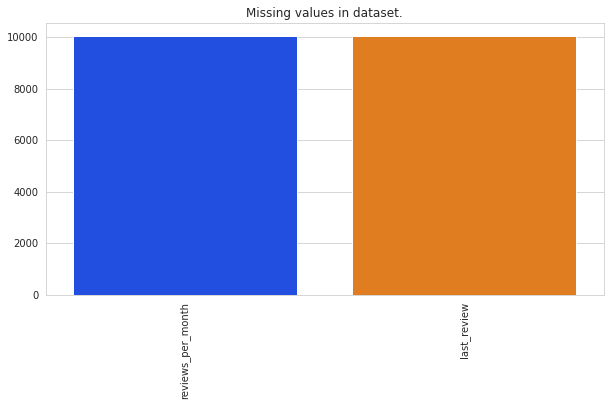

In [15]:
plt.figure(figsize=(10,5))
missing_plot = sns.barplot(x=missing_values.index[0:2],y=missing_values[0:2],palette='bright')
missing_plot.set_xticklabels(missing_plot.get_xticklabels(),rotation=90)
plt.title('Missing values in dataset.')
plt.show()

### Preview of missing features

In [16]:
data['last_review'].head()

0    2018-10-19
1    2019-05-21
2           NaN
3    2019-07-05
4    2018-11-19
Name: last_review, dtype: object

In [17]:
data['reviews_per_month'].head()

0    0.21
1    0.38
2     NaN
3    4.64
4    0.10
Name: reviews_per_month, dtype: float64

Analysing the missing values, the following conclusions can be ejected:
 - 'reviews_per_month' : fill NaN values with 0
 - 'host_name': fill NaN name with None
 - 'name' : fill NaN listing name with None
 - 'last_reviews': feature to drop

In [18]:
data['reviews_per_month'].fillna(value=0, inplace=True)
data.drop('last_review',axis=1,inplace=True)

Now the dataset is free of missing values.

In [19]:
data.isnull().sum().sum()

0

# Outliers
To detect ouliers in target - 'price', Tukey test will be implemented, which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values (IQR). Outliers are rows whose values are outside IQR.

In [20]:
def tukey_outliers(df, column):
  Q1 = np.percentile(df[column], 25)
  Q3 = np.percentile(df[column], 75)
  IQR = Q3 - Q1
  outlier_step = 1.5 * IQR
  outliers_index = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index
  return outliers_index

In [21]:
outliers_index = tukey_outliers(data,'price')
data.drop(outliers_index, inplace=True)
data.reset_index(drop=True, inplace=True)

# Zero values in 'price' 
Assuming that, you cannot rent a room for free. 0 values in target price may have a negative impact on the estimator. A good solution is to remove from the data samples whose price is 0. 

In [22]:
data[data['price']==0].head()

neighbourhood_group       neighbourhood  latitude  longitude  \
21946            Brooklyn  Bedford-Stuyvesant  40.69023  -73.95428   
24114               Bronx     East Morrisania  40.83296  -73.88668   
24304            Brooklyn            Bushwick  40.69467  -73.92433   
24420            Brooklyn          Greenpoint  40.72462  -73.94072   
24443            Brooklyn        Williamsburg  40.70838  -73.94645   

             room_type  price  minimum_nights  number_of_reviews  \
21946     Private room      0               4                  1   
24114     Private room      0               2                 55   
24304     Private room      0               2                 16   
24420     Private room      0               2                 12   
24443  Entire home/apt      0               5                  3   

       reviews_per_month  calculated_host_listings_count  availability_365  
21946               0.05                               4                28  
24114               2.56                               4               127  
24304               0.71                               5                 0  
24420               0.53                               2                 0  
24443               0.15                               1                73

In [23]:
print('Together we have {} listings with price equal to 0.'.format(len(data[data['price']==0])))

Together we have 11 listings with price equal to 0.


In [24]:
data[data['price']==0].index

Int64Index([21946, 24114, 24304, 24420, 24443, 24457, 24458, 24459, 24906,
            25462, 25486],
           dtype='int64')

In [25]:
data.drop(data[data['price']==0].index, inplace=True)

In [26]:
data.reset_index(drop=True, inplace=True)

# Entry visualizations
Distribution of accomodations through heatmaps.

In [27]:
NY_map = folium.Map([40.730610,-73.935242],zoom_start=10)
HeatMap(data[['latitude','longitude']],radius=10).add_to(NY_map)
display(NY_map)

The most densely spaced advertisements are marked in red and less dense green.

In [28]:
cluster_map = folium.Map([40.730610,-73.935242],zoom_start=10)
FastMarkerCluster(data[['latitude','longitude']],radius=10).add_to(cluster_map)
cluster_map

### Visualization 1: Share of neighbourhoods.
Number of listings in particural neighbourhoods.

In [29]:
listings = data['neighbourhood_group'].value_counts()
print(listings)

Manhattan        19505
Brooklyn         19406
Queens            5567
Bronx             1069
Staten Island      365
Name: neighbourhood_group, dtype: int64


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


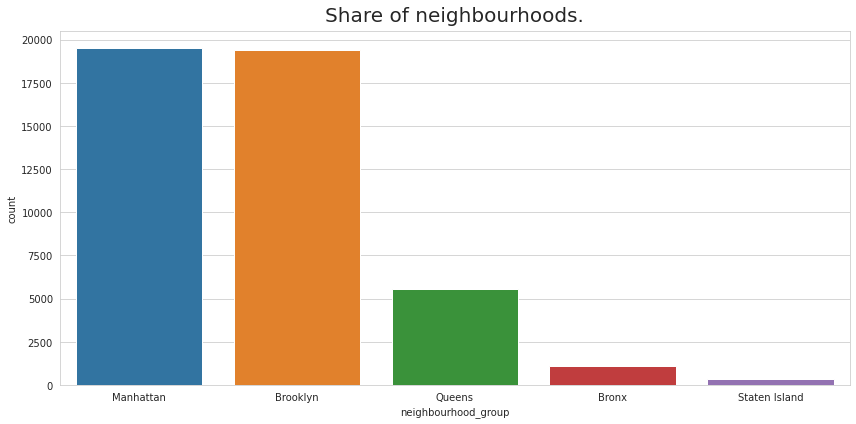

In [30]:
plt.figure(figsize=(12,6))
listings1plot=sns.countplot(data['neighbourhood_group'],order=data['neighbourhood_group'].value_counts().index)
plt.title('Share of neighbourhoods.',size=20,pad=10)
plt.tight_layout()

#### Conclusion
Manhattan and Brooklyn have the highest share of accomodations.

### Visualization 2: Top 25 most popular neighborhoods from advertisements.

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


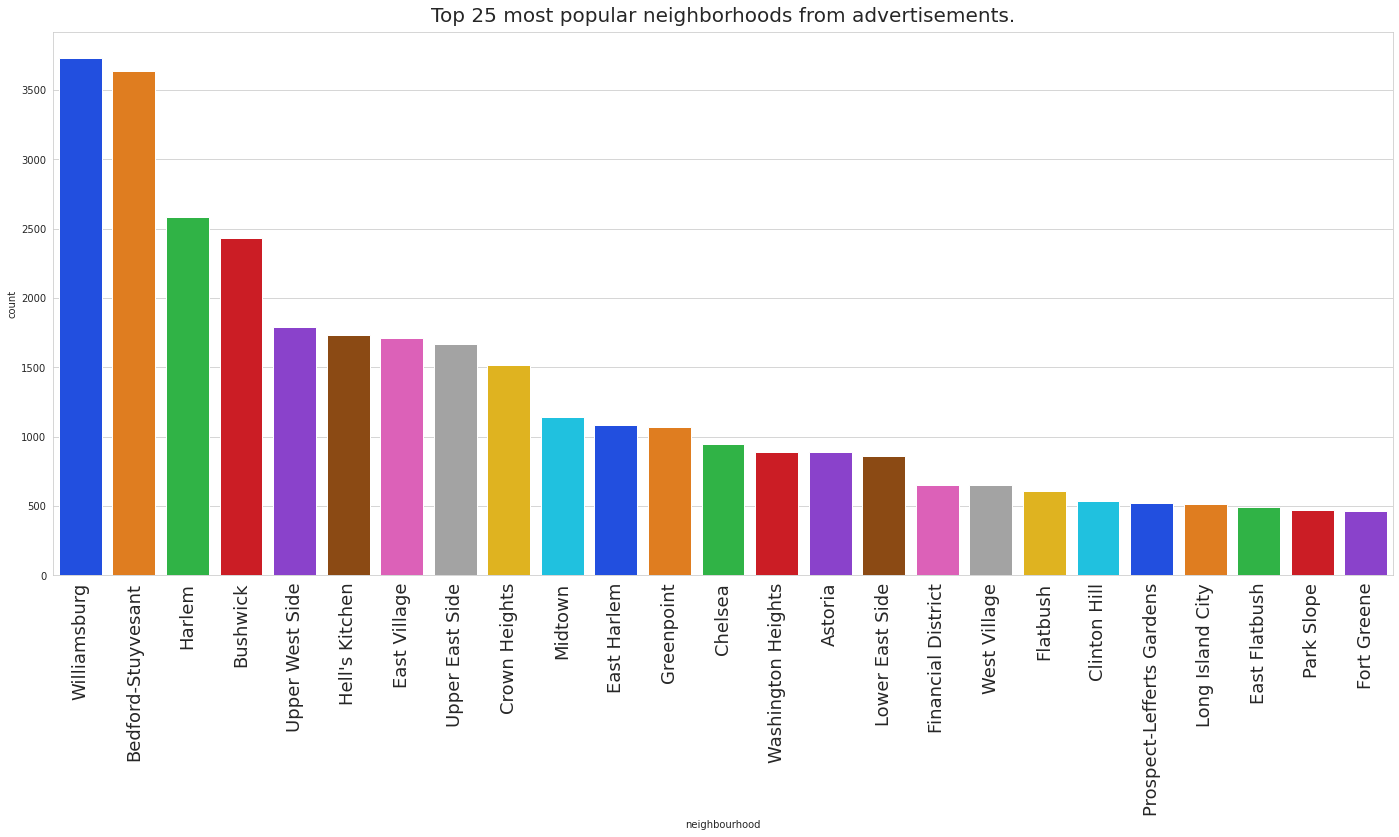

In [31]:
plt.figure(figsize=(24,10))
listings2plot = sns.countplot(data['neighbourhood'],order=data['neighbourhood'].value_counts().index[0:25],palette='bright')
listings2plot.set_xticklabels(listings2plot.get_xticklabels(),rotation=90, size=18)
plt.title('Top 25 most popular neighborhoods from advertisements.',size=20,pad=10)
plt.savefig('popular_neighbourhoods.png',bbox_inches='tight')
plt.show()

In [32]:
data[data.neighbourhood=='Williamsburg'].head(1)

neighbourhood_group neighbourhood  latitude  longitude        room_type  \
15            Brooklyn  Williamsburg  40.70837  -73.95352  Entire home/apt   

    price  minimum_nights  number_of_reviews  reviews_per_month  \
15    140               2                148                1.2   

    calculated_host_listings_count  availability_365  
15                               1                46

In [33]:
data[data.neighbourhood=='Bedford-Stuyvesant'].head(1)

neighbourhood_group       neighbourhood  latitude  longitude     room_type  \
6            Brooklyn  Bedford-Stuyvesant  40.68688  -73.95596  Private room   

   price  minimum_nights  number_of_reviews  reviews_per_month  \
6     60              45                 49                0.4   

   calculated_host_listings_count  availability_365  
6                               1                 0

In [34]:
data[data.neighbourhood=='Harlem'].head(1)

neighbourhood_group neighbourhood  latitude  longitude     room_type  price  \
2           Manhattan        Harlem  40.80902   -73.9419  Private room    150   

   minimum_nights  number_of_reviews  reviews_per_month  \
2               3                  0                0.0   

   calculated_host_listings_count  availability_365  
2                               1               365

#### Conclusion
Two of the three most popular districts are in Brooklyn and remaining one is in Manhattan.

### Visualization 3: Prices through districts.
Price for whole city:


In [35]:
data['price'].describe()

count    45912.000000
mean       119.999063
std         68.133003
min         10.000000
25%         65.000000
50%        100.000000
75%        159.000000
max        334.000000
Name: price, dtype: float64

The mean price of an advertisement will allow to better representation of advertisements locations by scattered plots.

In [36]:
# import urllib

# i=urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/e/ec/Neighbourhoods_New_York_City_Map.PNG')
# nyc_img=plt.imread(i)
# fig,(ax1, ax2) = plt.subplots(1,2,figsize=(32,8))

# ax1.imshow(nyc_img, extent=[-74.258, -73.7, 40.49, 40.92])
# ax2.imshow(nyc_img, extent=[-74.258, -73.7, 40.49, 40.92])
# plot1 = ax1.scatter(data['longitude'][data['price']<119], data['latitude'][data['price']<119], c=data['price'][data['price']<119], cmap='viridis', linewidth=1, alpha=0.6)
# plot2 = ax2.scatter(data['longitude'][data['price']>119], data['latitude'][data['price']>119], c=data['price'][data['price']>119], cmap='viridis', linewidth=1, alpha=0.6)
# cbar1 = fig.colorbar(plot1,ax=ax1)
# cbar2 = fig.colorbar(plot2,ax=ax2)
# cbar1.set_label('Price in USD',size=20)
# cbar2.set_label('Price in USD',size=20)

# ax1.set_title('Listings with price below mean.', size=20, pad=10)
# ax2.set_title('Listings with price above mean.', size=20, pad=10)
# plt.show()

#### Conclusion
Based on these two plots we can see that the accommodation with the highest price can be found in Brooklyn and Manhattan. 

### Visualization 4: Distribution of prices in particular districts.

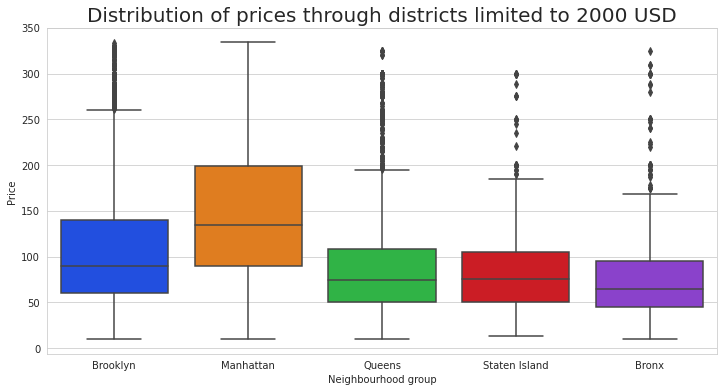

In [37]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data[data.price <2000], x='neighbourhood_group', y='price', palette='bright')
plt.title('Distribution of prices through districts limited to 2000 USD', fontsize=20)
plt.xlabel('Neighbourhood group')
plt.ylabel("Price")
plt.show()

In [38]:
data.groupby(["neighbourhood_group"])['price'].mean()

neighbourhood_group
Bronx             77.437792
Brooklyn         105.748634
Manhattan        145.960318
Queens            88.904437
Staten Island     89.235616
Name: price, dtype: float64

#### Conclusion
More detailed boxplot confirms that the highest prices are in Brooklyn and Manhattan. 


### Visualization 5: Prices through neighbourhoods.

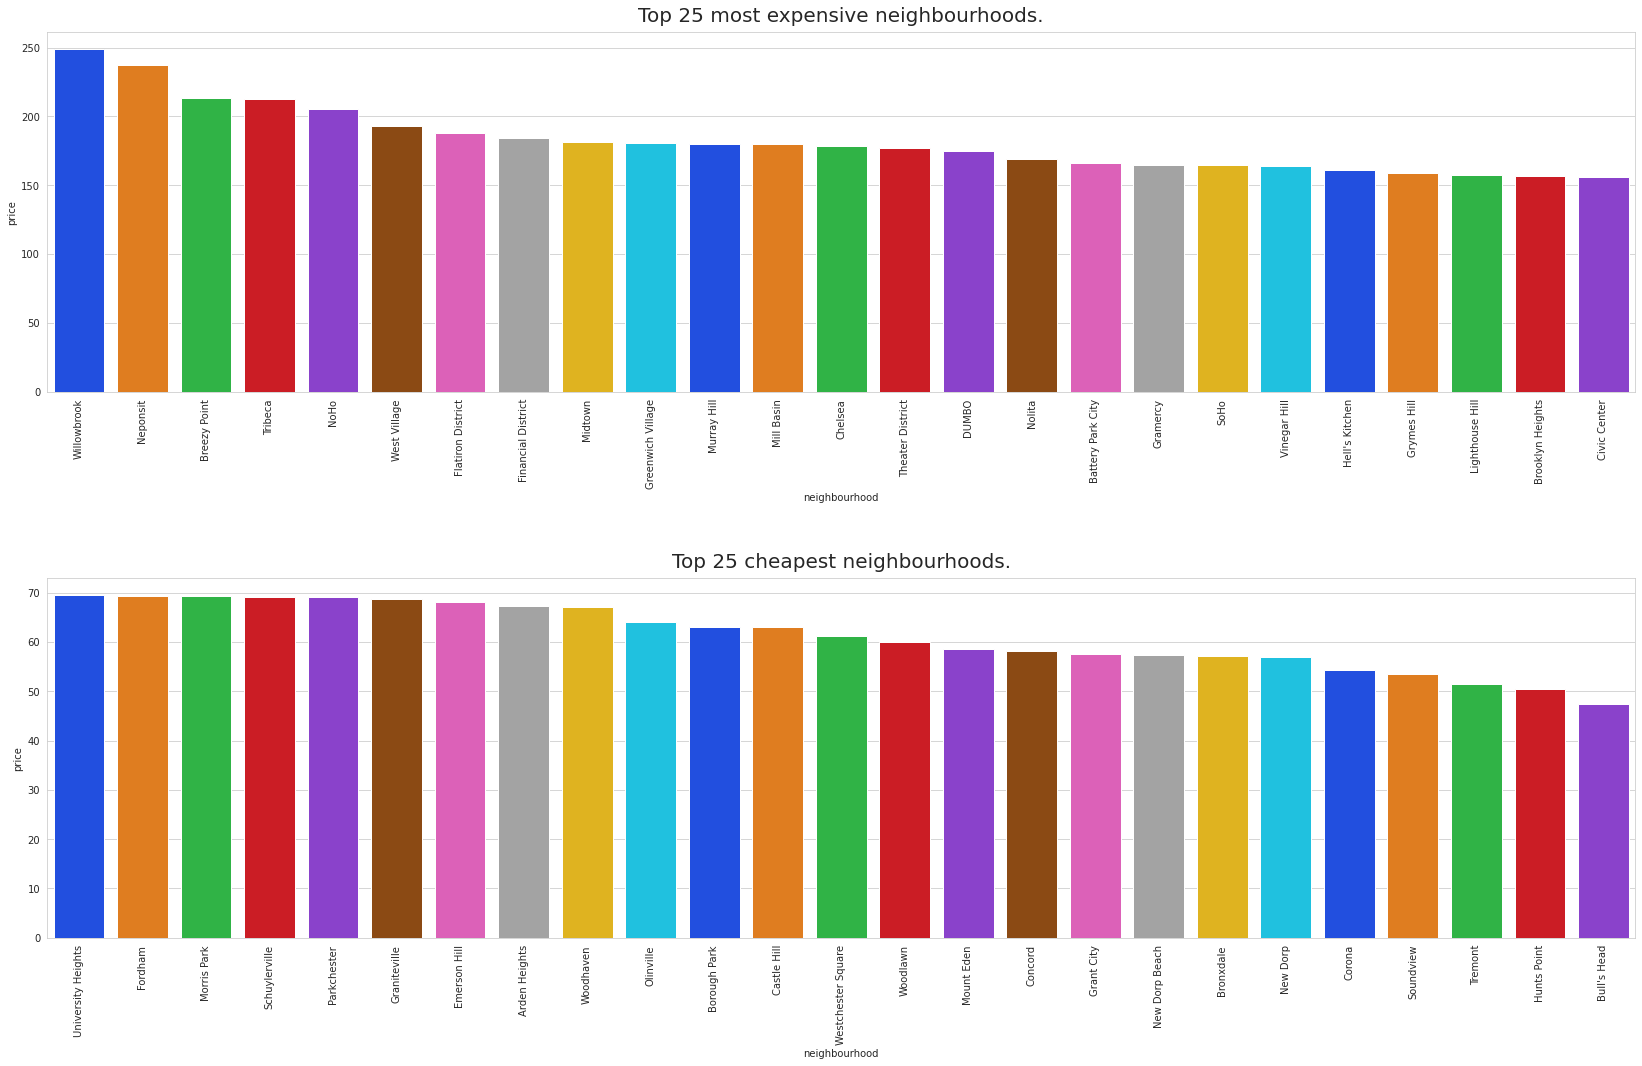

In [39]:
neighbourhood_mean_prices = data.groupby('neighbourhood').agg({'price': 'mean'}).sort_values('price',ascending=False).reset_index()
fig, ax = plt.subplots(2,1,figsize=(24,16))
neighbourhood_prices_max=sns.barplot(x=neighbourhood_mean_prices['neighbourhood'][0:25], y=neighbourhood_mean_prices['price'],palette='bright',ax=ax[0])
neighbourhood_prices_max.set_xticklabels(neighbourhood_prices_max.get_xticklabels(),rotation=90)
neighbourhood_prices_max.set_title("Top 25 most expensive neighbourhoods.",size=20,pad=10)
neighbourhood_prices_min=sns.barplot(x=neighbourhood_mean_prices['neighbourhood'][-25:], y=neighbourhood_mean_prices['price'],palette='bright',ax=ax[1])
neighbourhood_prices_min.set_xticklabels(neighbourhood_prices_min.get_xticklabels(),rotation=90)
neighbourhood_prices_min.set_title("Top 25 cheapest neighbourhoods.",size=20,pad=10)
fig.tight_layout(pad=5.0)
plt.show()

#### Conclusion
The highest average prices of accommodation can be found in Willowbrook and the cheapest accommodations are in Bull's head.

### Visualization 5: Minimun nights
Based on the heat map, we can see that the second most important feature in terms of correlation with 'price' is 'minimun nights'

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


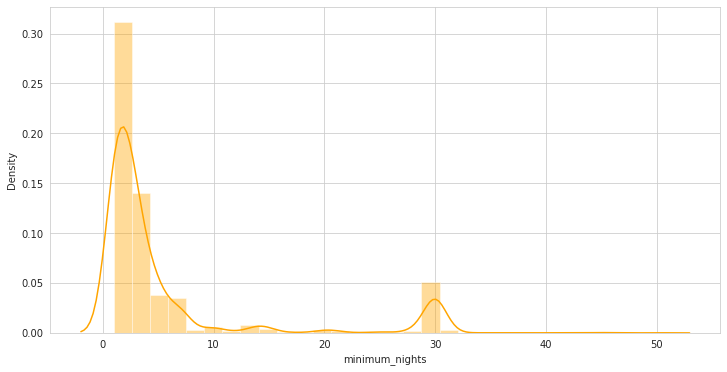

In [40]:
plt.figure(figsize = (12,6))
sns.distplot(data[(data['minimum_nights'] <= 50) & (data['minimum_nights'] > 0)]['minimum_nights'], bins=30, color='orange')
plt.ioff()

#### Conclusion
Based on distplot w can see that advertisements are booked mainly for 1 to 5 days but some part of advertisements are also booked for 30 days.

### Visualization 6: Room type vs price

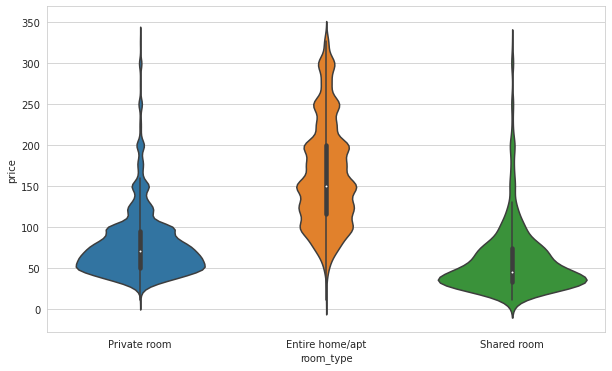

In [41]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
sns.violinplot(data=data, x='room_type', y='price')
plt.show()

#### Conclusion
Private rooms are most priced, we can conclude that most people are able to pay more for their privacy.

# Distribution of price (after Tukey test) and without price equal to 0

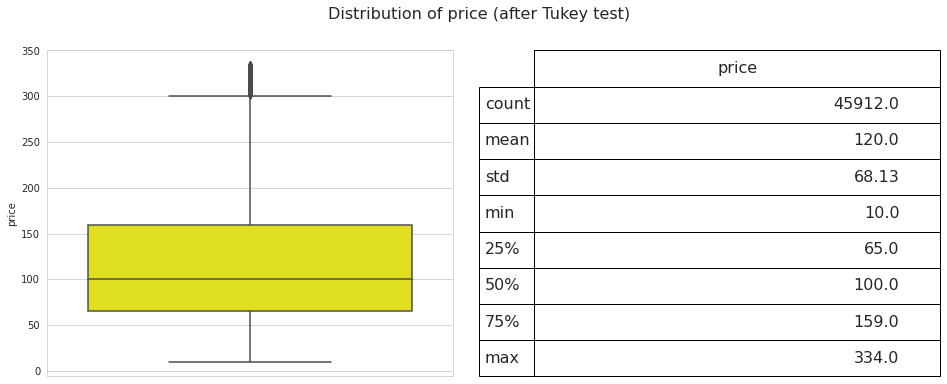

In [42]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(121)
sns.boxplot(y = data['price'], ax=ax1, color='yellow')
describe = data['price'].describe().to_frame().round(2)

ax2 = fig.add_subplot(122)
ax2.axis('off')
font_size = 16
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of price (after Tukey test)', fontsize=16)
plt.show()

Now it's cleat to see that distribution of target - 'price' looks way better. 

# Boxplots of particular features
Boxplots of particular quantitative features in dataset.

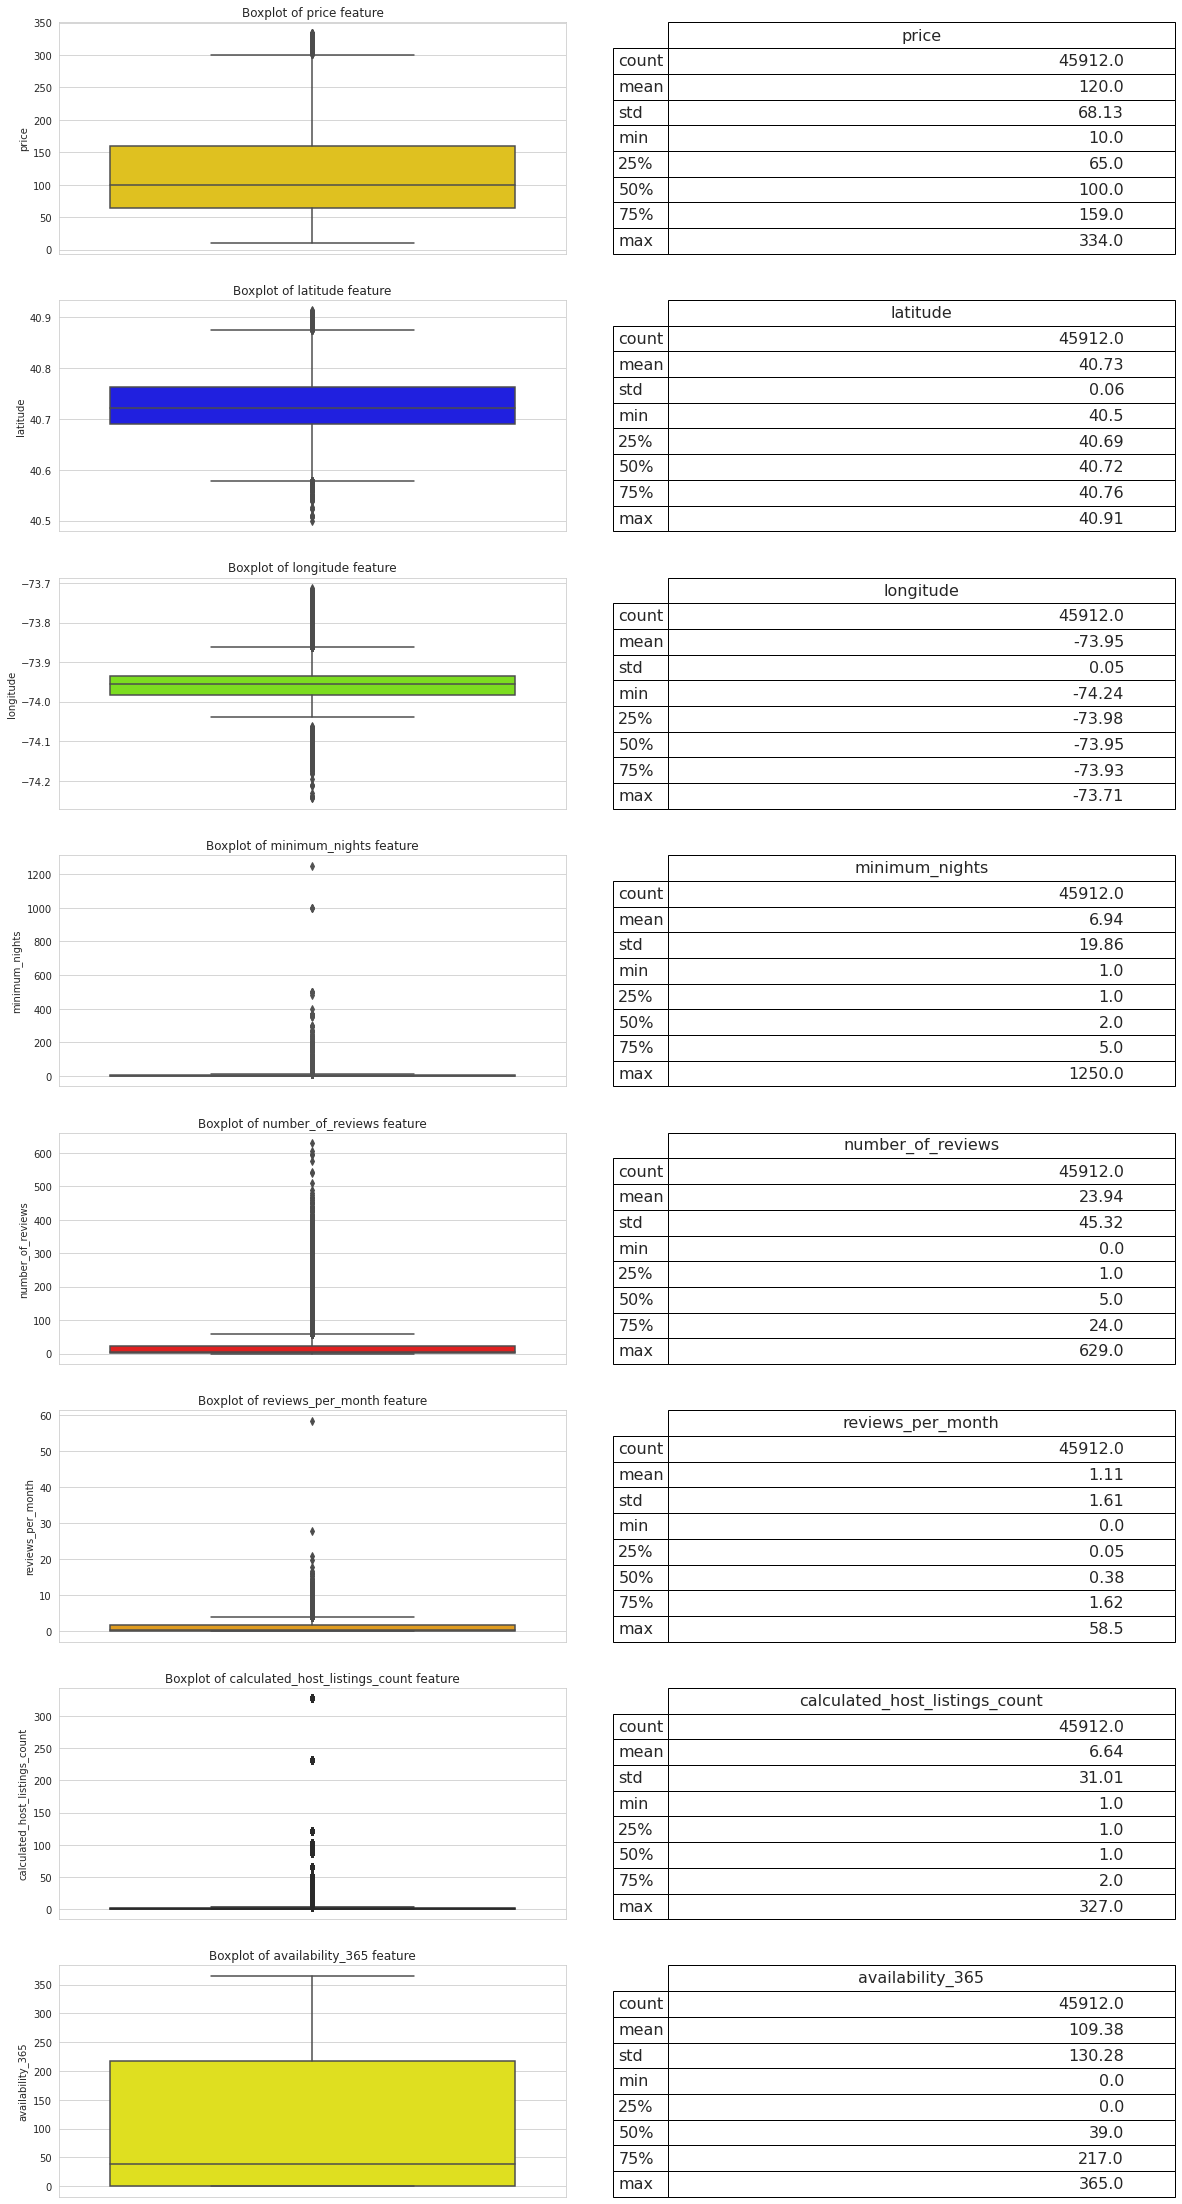

In [43]:
dists = data[['price','latitude', 'longitude', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365']]

fig, ax = plt.subplots(8,2,figsize=(20,40))
bbox = [0, 0, 1, 1]
fontsize = 15
colors = ['gold','blue','lawngreen','deeppink','red','orange','darkcyan','yellow']

for i in range(len(dists.columns)):
    describe = data[dists.columns[i]].describe().to_frame().round(2)
    sns.boxplot(y=data[dists.columns[i]],ax=ax[i][0], color=colors[i])
    table = ax[i][1].table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
    table.set_fontsize(font_size)
    ax[i][1].axis('off')
    ax[i][0].title.set_text('Boxplot of {} feature'.format(dists.columns[i]))



plt.show()

Many of features in dataset are really skewed. Proposed solution below.

# Box-Cox transformation on quantitative features
Let's start by checking how skewed quantitative characteristics are. 

**Note**: We will not carry out transformations on longitude and latitude because it does not make sense. 

In [44]:
dists = data[['price', 'minimum_nights',
       'calculated_host_listings_count','number_of_reviews','reviews_per_month','availability_365']]

skewed_features = []
for column in dists:
    skew = abs(data[column].skew())
    print('{:15}'.format(column), 
          'Skewness: {:05.2f}'.format(skew),'Min value: {}'.format(data[column].min()))

price           Skewness: 00.92 Min value: 10
minimum_nights  Skewness: 21.93 Min value: 1
calculated_host_listings_count Skewness: 08.40 Min value: 1
number_of_reviews Skewness: 03.63 Min value: 0
reviews_per_month Skewness: 03.32 Min value: 0.0
availability_365 Skewness: 00.81 Min value: 0


To transform skewed features we need to use two types of Box-Cox transformation.Becouse some of features have got samples with values are near 0, this causes an error in boxcox transformation from SciPy package. It is possible to bypass this error by using boxcox1p transformation but for this type of transformation we must calculate lambda coefficient manually.

With the following transformation we are able to calculate the lambda coefficient for samples with values which are close to zero.

In [45]:
#Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')

### 'price' feature

In [46]:
data['price'],price_lambda = boxcox(data['price'])
print('"price lambda": {}'.format(price_lambda))

"price lambda": 0.08383467575305965


### 'minimum_nights' feature

In [47]:
data['minimum_nights'],lam = boxcox(data['minimum_nights'])
print('"minimum_nights lambda": {}'.format(lam))

"minimum_nights lambda": -0.4644546982027765


### 'calculated_host_listings_count' feature

In [48]:
data['calculated_host_listings_count'],lam = boxcox(data['calculated_host_listings_count'])
print('calculated_host_listings_count: {}'.format(lam))

calculated_host_listings_count: -1.322615384279007


### 'number_of_reviews' feature 

In [49]:
values = data['number_of_reviews'].values
data1 = pd.DataFrame({'x':values})
pt.fit(data1)
print(pt.lambdas_)

[-0.12794738]


In [50]:
data['number_of_reviews']= boxcox1p(data['number_of_reviews'],pt.lambdas_)
print('"number_of_reviews lambda: {}"'.format(pt.lambdas_))

"number_of_reviews lambda: [-0.12794738]"


### 'reviews_per_month' feature

In [51]:
values = data['reviews_per_month'].values
data2 = pd.DataFrame({'x':values})
pt.fit(data2)
print(pt.lambdas_)

[-1.04774384]


In [52]:
data['reviews_per_month']= boxcox1p(data['reviews_per_month'],pt.lambdas_)
print('"reviews_per_month lambda: {}"'.format(pt.lambdas_))

"reviews_per_month lambda: [-1.04774384]"


### 'availability_365' feature

In [53]:
values = data['availability_365'].values
data3 = pd.DataFrame({'x':values})
pt.fit(data3)
print(pt.lambdas_)

[0.06779621]


In [54]:
data['availability_365']= boxcox1p(data['availability_365'],-1.84047863)
print('"availability_365 lambda: {}"'.format(pt.lambdas_))

"availability_365 lambda: [0.06779621]"


## Preview of features after transformations.

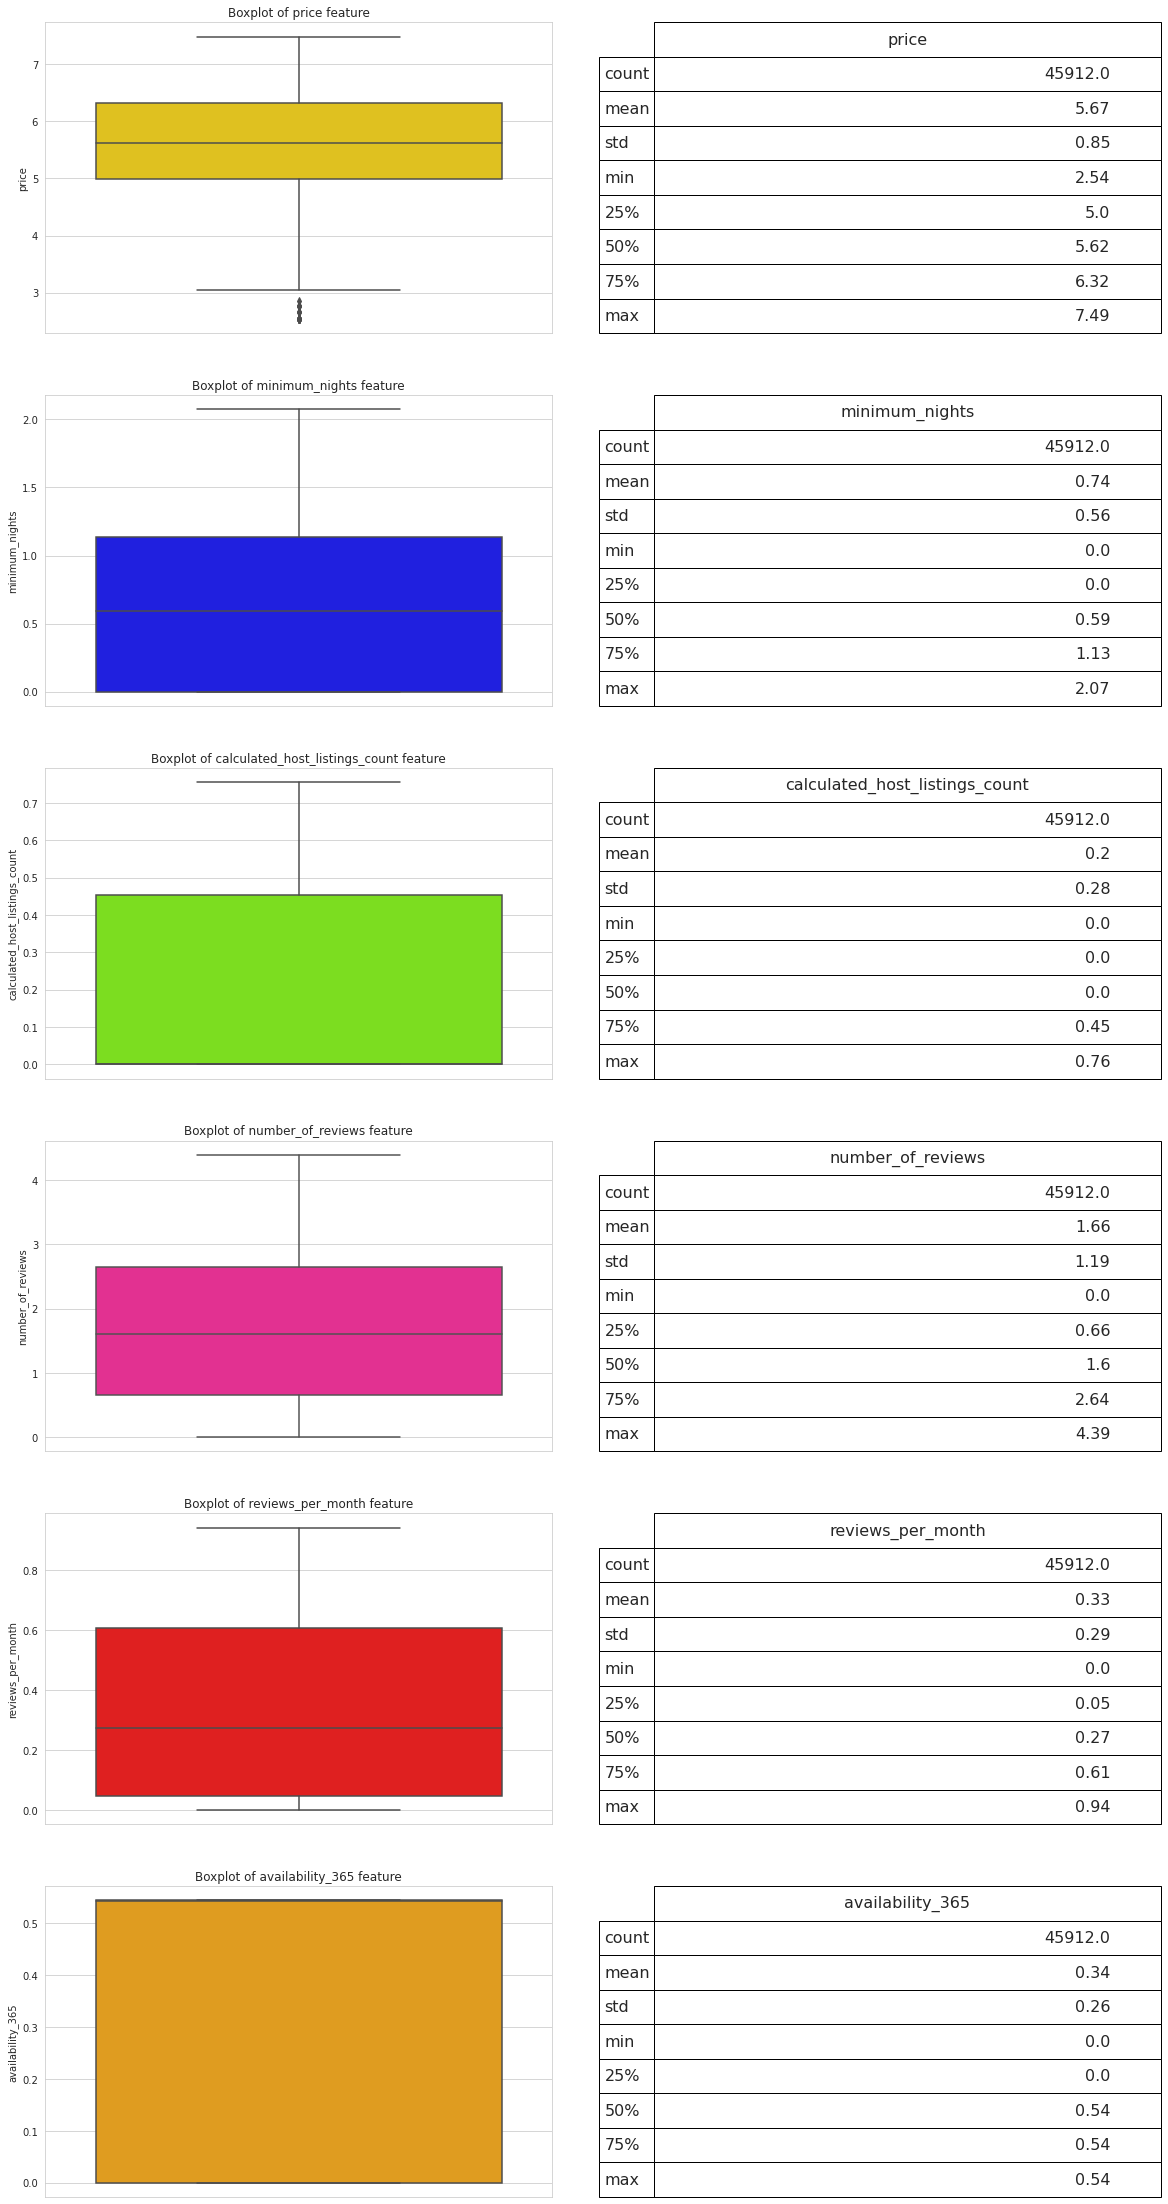

In [55]:
dists = data[['price', 'minimum_nights',
       'calculated_host_listings_count','number_of_reviews','reviews_per_month','availability_365']]

fig, ax = plt.subplots(6,2,figsize=(20,40))
bbox = [0, 0, 1, 1]
fontsize = 15
colors = ['gold','blue','lawngreen','deeppink','red','orange','darkcyan','yellow']

for i in range(len(dists.columns)):
    describe = data[dists.columns[i]].describe().to_frame().round(2)
    sns.boxplot(y=data[dists.columns[i]],ax=ax[i][0], color=colors[i])
    table = ax[i][1].table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
    table.set_fontsize(font_size)
    ax[i][1].axis('off')
    ax[i][0].title.set_text('Boxplot of {} feature'.format(dists.columns[i]))



plt.show()

As we can see from the graphs. Despite efforts, the transformation of the box cox has brought only minor improvements in case of distributions.

# Convert 'object' features into quantative ones
There are many different districts in the dataset, so to keep them in order label encoder has been used.

In [56]:
labelencoder = LabelEncoder()
data['neighbourhood'] = labelencoder.fit_transform(data['neighbourhood'])
data['neighbourhood_group'] = labelencoder.fit_transform(data['neighbourhood_group'])

For the remaining feature - 'room_type' get_dummies method will by applied on dataset.

In [57]:
data = pd.get_dummies(data)

Preview of final dataset.

In [58]:
data.head()

neighbourhood_group  neighbourhood  latitude  longitude     price  \
0                    1            107  40.64749  -73.97237  6.217083   
1                    2            126  40.75362  -73.98377  6.855013   
2                    2             93  40.80902  -73.94190  6.227262   
3                    1             41  40.68514  -73.95976  5.449882   
4                    2             61  40.79851  -73.94399  5.295255   

   minimum_nights  number_of_reviews  reviews_per_month  \
0        0.000000           1.994396           0.172791   
1        0.000000           3.026953           0.273369   
2        0.860488           0.000000           0.000000   
3        0.000000           3.999114           0.798621   
4        1.414135           1.994396           0.090706   

   calculated_host_listings_count  availability_365  \
0                        0.685385          0.543327   
1                        0.453791          0.543326   
2                        0.000000          0.543327   
3                        0.000000          0.543304   
4                        0.000000          0.000000   

   room_type_Entire home/apt  room_type_Private room  room_type_Shared room  
0                          0                       1                      0  
1                          1                       0                      0  
2                          0                       1                      0  
3                          1                       0                      0  
4                          1                       0                      0

 # Corrplot after all data transformations

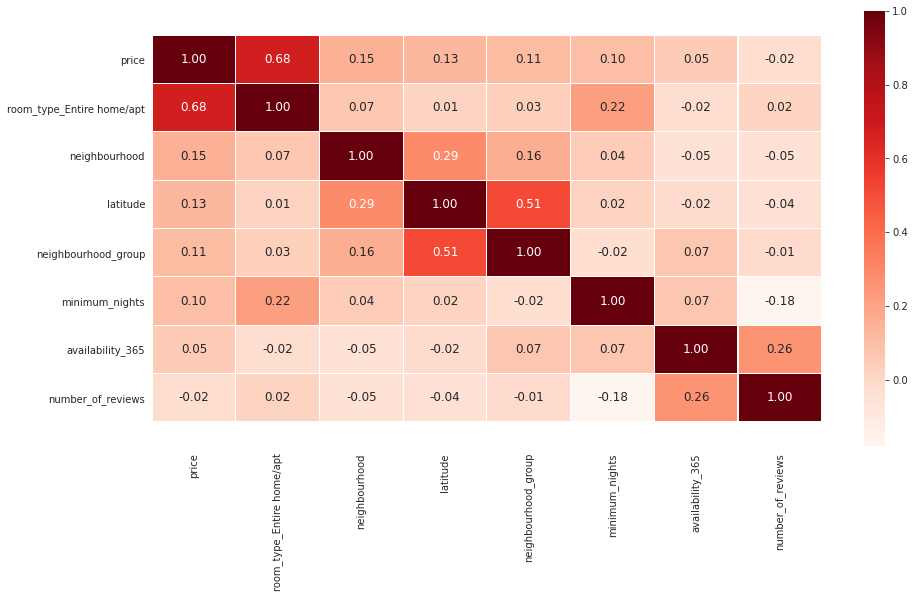

In [59]:
top = 8
corr = data[['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count','neighbourhood', 'neighbourhood_group', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room', 'availability_365']].corr(method='spearman')
top8 = abs(corr.nlargest(top,'price')['price']).index
corr_top8 = data[top8].corr(method='spearman')
plt.figure(figsize=(15,8))
ax = sns.heatmap(corr_top8, annot=True, linewidths=0.1, fmt='.2f', cmap='Reds', annot_kws={'size':12})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('corr_processed.png')

Corrplot clearly shows that the transformations carried out did not result in higher correlations between features and target. However, we can observe quite high correlation (considering this particular nasty data set) between room_type_Entire home/apt and target. 

# Predictive models

In [60]:
target = data['price']

In [61]:
data.drop('price', axis=1, inplace=True)

## Train test split 

In [62]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = .2, random_state=42)

In [63]:
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (36729, 12)
Dimensions of the training target vector: (36729,)
Dimensions of the test feature matrix: (9183, 12)
Dimensions of the test target vector: (9183,)


In [64]:
n_folds = 5

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 64).get_n_splits(data)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

## Simple model scoring by cross validation

In [65]:
for LinearModel in [LinearRegression, RandomForestRegressor, XGBRegressor]:
    if LinearModel == XGBRegressor: 
        reg = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else: 
        reg = rmse_cv(LinearModel())
    print('{}: {:.3f} +/- {:.3f}'.format(LinearModel.__name__, -reg.mean(), reg.std()))

LinearRegression: 0.345 +/- 0.005
RandomForestRegressor: 0.264 +/- 0.005
XGBRegressor: 0.262 +/- 0.005


## Metrics for models

### MSE

def rmse(actual,predicted):
    return(np.sqrt(mean_squared_error(actual, predicted)))

### Scores sumary

def model_scores(model, cv_model, y_train, y_test, pred_train, pred_test):
    mse = mean_squared_error(y_test, lin_reg_pred_test)
    results = pd.DataFrame({'Model':['{}'.format(type(model).__name__)],
                'CV error': '{:.3f}'.format(cv_model.mean()), 
                'CV std': '{:.3f}'.format(cv_model.std()),
                'RMSE train': [rmse(y_train, pred_train)],
                'RMSE test': [rmse(y_test, pred_test)],
                'R2 train': [r2_score(y_train, pred_train)],
                'R2 test': [r2_score(y_test, pred_test)]})
    results = results.round(decimals=4)

    return results

# Model interpretations
Model interpretations will be performed for the 500th data sample.
LimeTabularExplainer prefer np.arrays as input.

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=data.columns, class_names=['price'], verbose=True, mode='regression')
i = 500

## Linear Regression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

lin_reg_cv = -rmse_cv(LinearRegression())
lin_reg_pred_train = lin_reg.predict(X_train)
lin_reg_pred_test = lin_reg.predict(X_test)

lin_reg_results = model_scores(lin_reg, lin_reg_cv, y_train, y_test, lin_reg_pred_train, lin_reg_pred_test)

lin_reg_results.style.hide_index()

lin_reg.coef_

eli5.show_weights(lin_reg, feature_names=list(data.columns))

exp = explainer.explain_instance(X_test[i], lin_reg.predict, num_features=5)

exp.show_in_notebook(show_table=True)

## Random Forest

rfr_reg = RandomForestRegressor(random_state=42)
rfr_reg.fit(X_train, y_train) 

rfr_reg_cv = -rmse_cv(RandomForestRegressor())
rfr_pred_train = rfr_reg.predict(X_train)
rfr_pred_test = rfr_reg.predict(X_test)

rfr_reg_results = model_scores(rfr_reg, rfr_reg_cv, y_train, y_test, rfr_pred_train, rfr_pred_test)

rfr_reg_results.style.hide_index()

eli5.show_weights(rfr_reg, feature_names=list(data.columns))

exp = explainer.explain_instance(X_test[i], rfr_reg.predict, num_features=5)

exp.show_in_notebook(show_table=True)

## XGBoost regressor

xgb_reg = XGBRegressor(n_estimators=1000)
xgb_reg.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

xgb_reg = XGBRegressor(learning_rate=0.3,
                      n_estimators=1000,
                      max_depth=6, min_child_weight=1)

xgb_reg_cv = -rmse_cv(xgb_reg)

xgb_reg.fit(X_train, y_train)
xgb_pred_train = xgb_reg.predict(X_train)
xgb_pred_test = xgb_reg.predict(X_test)

xgb_reg_results = model_scores(xgb_reg, xgb_reg_cv, y_train, y_test, xgb_pred_train, xgb_pred_test)

xgb_reg_results.style.hide_index()

eli5.show_weights(xgb_reg, feature_names=list(data.columns))

exp = explainer.explain_instance(X_test[i], xgb_reg.predict, num_features=5)

exp.show_in_notebook(show_table=True)

# Actual vs predicted values

### Box-cox inversion
To read actual and predicted prices in dollars, price inversion is requiured. To present predicted values, Random Forest Regressor will be used. Apart from the fact of noticeable overfitting, this model achieved the best result for the test set RMSE ~ 0.51.

#Actual
y_test = inv_boxcox(y_test, price_lambda)
y_train = inv_boxcox(y_train, price_lambda)

#Predicted
rfr_pred_train = inv_boxcox(rfr_pred_train, price_lambda)
rfr_pred_test = inv_boxcox(rfr_pred_test, price_lambda)

results = pd.DataFrame({
                'MSE train': [mean_squared_error(y_train, rfr_pred_train)],
                'MSE test': [mean_squared_error(y_test, rfr_pred_test)],
                'RMSE train': [np.sqrt(mean_squared_error(y_train, rfr_pred_train))],
                'RMSE test': [np.sqrt(mean_squared_error(y_test, rfr_pred_test))],
                'R2 train': [r2_score(y_train, rfr_pred_train)],
                'R2 test': [r2_score(y_test, rfr_pred_test)]})
results = results.round(decimals=4)
results

error = pd.DataFrame({'Real Values': np.array(y_test).flatten(), 'Predicted Values': rfr_pred_test.flatten()})
error.head(10)

### Final visualization: Evaluated predictions 

plt.figure(figsize=(15,7))
sns.regplot(y=rfr_pred_test, x=y_test, line_kws={"color": "red"}, color='springgreen')
plt.title('Evaluated predictions', fontsize=15)
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.show()

# Conclusions
* Poor data quality and in particular uneven distributions of features made it difficult to build a good predictive model.

* Multiple operations performed on given dataset did not bring any significant improvement in the obtained predictions of prices.

* Deeper dive into given problem and extending dataset with more valuable features manifesting better correlation with target could result in obtaining better predictions.